In [1]:
import numpy as np
import bls_cpu as gbls
import transitPy5 as tpy5
import os
# os.environ["OMP_NUM_THREADS"] = "48"

In [2]:
import importlib

In [3]:
importlib.reload(gbls)

<module 'bls_cpu' from '/home/aroy/bls_cuda/bls_cpu.py'>

In [ ]:
gbls_inputs = gbls.gbls_inputs_class() # Initialize needed inputs

tic = 29991541
gbls_inputs.lcdir    = "/opt/data2/TESS/ffisearch/cvzsearch_yr1/cvz1pt003/tlc"+str(tic)+"/"
# gbls_inputs.filename = "tlc"+str(tic)+"_5.dc.dat"
gbls_inputs.filename = "tlc"+str(tic)+".dat"

# Read in photometry to photclass
phot = tpy5.readphot(gbls_inputs.lcdir + gbls_inputs.filename)

# Remove any offset from time stamps
gbls_inputs.zerotime = 1325.0

# 0 == no plots ; 1 = make a plot ; 2 make a plot and save it ; 3 just save the plot
gbls_inputs.plots = 1  #default is 1 

# Set frequency range by setting freqs1 and freqs2
# gbls_inputs.freq1 = 1/100 # scan from 100 days to 2 days
# gbls_inputs.freq2 = 1/2

# Set stellar parameters for optimum duration search
# gbls_inputs.Mstar = 1.0  #default is M = 1, R = 1
# gbls_inputs.Rstar = 1.0

# Set multipro = 0 for single thread jobs.  Default is 1.  
# gbls_inputs.multipro = 1

In [5]:
## Data processing 

# # Simple sigma cut on the data
# fstd = np.std(phot.flux)
# fstd_flag  = (np.abs(phot.flux - np.median(phot.flux)) < tpy5_inputs.fstd_cut*fstd) # & badcut
# phot.time  = phot.time[fstd_flag]
# phot.flux  = phot.flux[fstd_flag]
# phot.ferr  = phot.ferr[fstd_flag]
# phot.itime = phot.itime[fstd_flag]
# phot.tflag = phot.tflag[fstd_flag]
# phot.icut  = phot.icut[fstd_flag]


# This class will eventually end up in tpy5.  Will move when input parameters is more complete.  
class tpy5_inputs_class:
    def __init__(self):
        self.photfile  = "filename.txt"
        self.photdir   = "/path/to/photometry/"
        self.roi       = 210.01 # Roman ID
        self.boxbin    = 5.0    # Detrending window
        self.gapsize   = 0.5    # Detection of gaps in the data -- we do not detrend over gaps
        self.nfitp     = 2      # Order of polynomial for detrending.  2 = quadratic
        self.dsigclip  = 3.0    # Sigma clipping for derivative routine
        self.nsampmax  = 6      # Sample size for derivative routine
        self.detrended = 0      # Track if detrended data is used/created
        self.dataclip  = 0      # Track if clipped data is used/created 
        self.fstd_cut  = 3      # Simple Sigma-clipping

tpy5_inputs = tpy5_inputs_class()

# Detrender
tpy5.run_polyfilter(phot, tpy5_inputs) # -- will add flux_f to phot class

# Outlier rejection
tpy5.run_cutoutliers(phot, tpy5_inputs)

# Simple sigma cut on the data
fstd = np.std(phot.flux)
fstd_flag  = (np.abs(phot.flux - np.median(phot.flux)) < tpy5_inputs.fstd_cut*fstd) # & badcut

In [6]:
# importlib.reload(gbls)

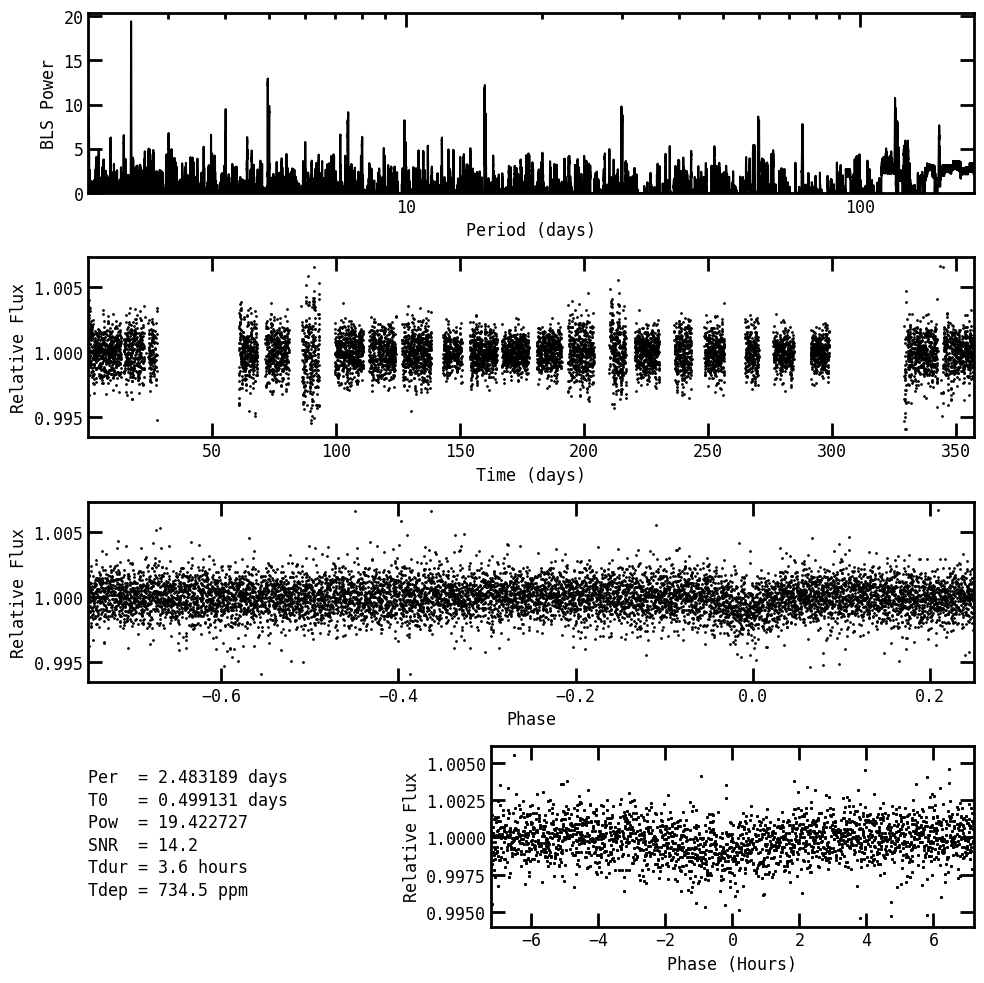

In [7]:
# If you used data processing, use phot.flux_f
# importlib.reload(gbls)
gbls_inputs.freq1 = 2/(np.max(phot.time) - np.min(phot.time))
gbls_inputs.freq2 = 0.5
gbls_ans = gbls.bls(gbls_inputs, phot.time[fstd_flag & (phot.icut == 0)], phot.flux_f[fstd_flag & (phot.icut == 0)])

## Python Transit modelling section

In [8]:
import utils_python.transitmodel as transitm
import utils_python.keplerian as kep
import utils_python.transitfit as transitf
import utils_python.transitplot as transitp
from exotic_ld import StellarLimbDarkening

/home/aroy/venv/lib/python3.13/site-packages/exotic_ld/ld_grids.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [ ]:
# Create an initial guess for all 18 parameters
sol = transitm.transit_model_class() # Single planet model has up-to 18-model parameters
sol.rho = kep.rhostar(gbls_ans.bper, gbls_ans.tdur)    # Mean stellar density (g/cm^3)
sol.nl1 = 0.0    # Only used for non-linear limb-darkening
sol.nl2 = 0.0    # Only used for non-linear limb-darkening
sol.dil = 0.0    # dilution
sol.vof = 0.0    # Velocity offset
sol.zpt = 0.0    # Photometric zero point
sol.t0  = [gbls_ans.epo]             # Center of transit time (days)
sol.per = [gbls_ans.bper]            # Orbital Period (days)
sol.bb  = [0.5]                      # Impact parameter
sol.rdr = [np.sqrt(gbls_ans.depth)]  # Rp/R*
sol.ecw = [0.0]  # sqrt(e)cos(w)
sol.esw = [0.0]  # sqrt(e)sin(w)
sol.krv = [0.0]  # RV amplitude (m/s)
sol.ted = [0.0]  # thermal eclipse depth (ppm)
sol.ell = [0.0]  # Ellipsodial variations (ppm)
sol.alb = [0.0]  # Albedo amplitude (ppm)
sol.npl = 1         # Number of planets

# Find Kipping limb-darkening coefficients
M_H = 0.2
Teff = 5400
logg = 4.45

ld_data_path = '/opt/data2/rowe/exotic_ld_data/'  #Remove 'opt' for exo/kona
ld_model = 'mps1'
sld = StellarLimbDarkening(M_H, Teff, logg, ld_model, ld_data_path)
ld, ld_sig = sld.compute_kipping_ld_coeffs(wavelength_range=[0.6*10000, 1.0*10000], mode="TESS", mu_min=0.1, return_sigmas=True)
sol.nl3 = ld[0]
sol.nl4 = ld[1]

In [10]:
# Flag data in transit
tdurcut = 2

time_a = phot.time - gbls_inputs.zerotime
phase = (time_a - sol.t0[0])/sol.per[0] - np.floor((time_a - sol.t0[0])/sol.per[0])
phase[phase<-0.5] += 1.0
phase[phase>0.5] -= 1.0

tdur = kep.transitDuration(sol, 0)/sol.per[0]

phot.tflag = (phase > -tdurcut*tdur) & (phase < tdurcut*tdur)

# Preconditioning of data
tpy5.run_polyfilter(phot, tpy5_inputs) # Will add flux_f to phot class
tpy5.run_cutoutliers(phot, tpy5_inputs) # Adds icut to bad data

phot.ferr = np.full(len(phot.flux_f), np.std(phot.flux_f))

In [11]:
# Define the parameters to fit
params_to_fit = ["rho", "zpt", "t0", "per", "bb", "rdr"]

# Fit the data (Handles phot.flux_f and phot.icut)
sol_fit = transitf.fitTransitModel(sol, params_to_fit, phot, zerotime=gbls_inputs.zerotime, use_icut=True, use_flux_f=True)

In [12]:
# Plotting
transitp.printParams(sol_fit)

ρ* (g/cm³):                     0.1696128 ± 4.8470117
c1:                                   0.0 ± 0.0
c2:                                   0.0 ± 0.0
q1:                             0.3545084 ± 0.0000000
q2:                             0.3205229 ± 0.0000000
Dilution:                             0.0 ± 0.0
Velocity Offset:                      0.0 ± 0.0
Photometric zero point:         2.992e-06 ± 2.358e-05
t0 (days):                      0.4487594 ± 0.0120299
Period (days):                  2.4835490 ± 0.0001467
Impact parameter:               0.5604802 ± 12.6723010
Rp/R*:                          0.0279767 ± 0.0596324
sqrt(e)cos(w):                        0.0 ± 0.0
sqrt(e)sin(w):                        0.0 ± 0.0
RV Amplitude (m/s):                   0.0 ± 0.0
Thermal eclipse depth (ppm):          0.0 ± 0.0
Ellipsoidal variations (ppm):         0.0 ± 0.0
Albedo amplitude (ppm):               0.0 ± 0.0


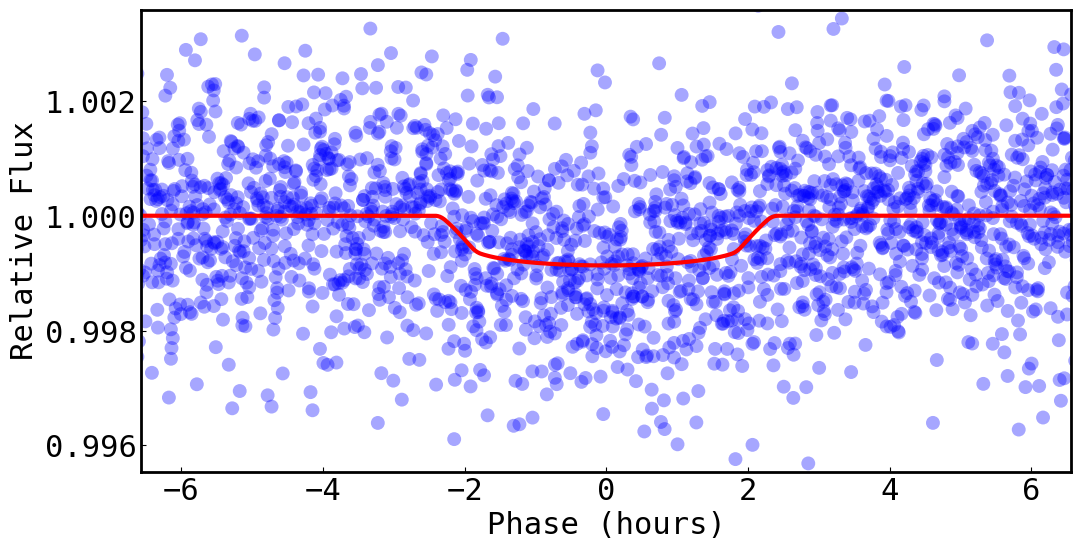

In [13]:
pl_plot = 1
transitp.plotTransit(phot, sol_fit, pl_to_plot=pl_plot, zerotime=gbls_inputs.zerotime, use_icut=True, use_flux_f=True)

## MCMC

In [21]:
import utils_python.transitmcmc as tmcmc
import utils_python.mcmcroutines as mcmc
import matplotlib.pyplot as plt

In [15]:
nsteps1 = 10000 #total length of chain will be nwalkers*nsteps
nsteps2 = 50000#200000 #nstep1 is to check that MCMC is okay, nstep2 is the real work.
nsteps_inc = 50000#100000
burninf=0.3 #burn-in for evalulating convergence
niter_cor=5000
burnin_cor=1000
nthin=101
nloopmax=5
converge_crit=1.02 #Convergence criteria
buf_converge_crit=1.2 #Convergence criteria for buffer

In [16]:
# Bring up the data to have median around 1
# phot.flux += 1
if np.rint(np.median(phot.flux)) != 1:
    raise ValueError

# Generate input for mcmc
lnprob, x, beta = tmcmc.genmcmcInput(sol_fit, params_to_fit)
sol_a = sol_fit.to_array()
serr = sol_fit.err_to_array()

# Cut out of transit
phot_cut = tmcmc.cutOutOfTransit(sol_fit, phot, zerotime=gbls_inputs.zerotime, tdurcut=1, cut_flux_f=True, cut_icut=True)

params = [nsteps1, nsteps2, nsteps_inc, burninf, niter_cor, burnin_cor, nthin, nloopmax, converge_crit, buf_converge_crit]

In [19]:
chain, accept, burnin = tmcmc.demcmcRoutine(x, beta, phot_cut, sol_a, serr, params, lnprob,
                                            zerotime=gbls_inputs.zerotime, verbose=True, progress_bar=True, use_flux_f=True, use_icut=True)

Prior: 0


100%|██████████| 5000/5000 [00:07<00:00, 642.48it/s]


runtest: [1.23522004e-02 1.10519688e-02 8.65827290e-05 1.80613435e-04]


100%|██████████| 5000/5000 [00:07<00:00, 668.84it/s]


Current Acceptance:  [0.01065449 0.874613   0.57824143 0.58396369 0.0089153  0.04148784]


100%|██████████| 5000/5000 [00:07<00:00, 657.03it/s]


Current Acceptance:  [0.04041916 0.5286533  0.30981595 0.36240602 0.0208     0.09298999]


100%|██████████| 5000/5000 [00:07<00:00, 651.05it/s]


Current Acceptance:  [0.20119225 0.14135338 0.19942611 0.17912773 0.19758673 0.21823617]


100%|██████████| 5000/5000 [00:07<00:00, 625.06it/s]


Current Acceptance:  [0.403125   0.0821727  0.14130435 0.14450867 0.28854962 0.31458967]


100%|██████████| 5000/5000 [00:08<00:00, 611.41it/s]


Current Acceptance:  [0.42640364 0.11497731 0.17351598 0.17251908 0.48108926 0.37955182]


100%|██████████| 5000/5000 [00:08<00:00, 616.70it/s]


Current Acceptance:  [0.36940837 0.20359281 0.26093514 0.24626866 0.51156069 0.28985507]


100%|██████████| 5000/5000 [00:07<00:00, 625.94it/s]


Current Acceptance:  [0.278125   0.321875   0.26093514 0.24626866 0.35346097 0.24787535]


100%|██████████| 5000/5000 [00:08<00:00, 599.43it/s]


Current Acceptance:  [0.278125   0.32075472 0.26093514 0.24626866 0.18287373 0.24787535]


100%|██████████| 5000/5000 [00:08<00:00, 621.61it/s]


Current Acceptance:  [0.278125   0.31839258 0.26093514 0.24626866 0.14589666 0.24787535]


100%|██████████| 5000/5000 [00:07<00:00, 633.10it/s]


Current Acceptance:  [0.278125   0.22525108 0.26093514 0.24626866 0.20524691 0.24787535]


100%|██████████| 5000/5000 [00:10<00:00, 489.36it/s]


Current Acceptance:  [0.278125   0.22525108 0.26093514 0.24626866 0.13207547 0.24787535]
Too many iterations: icount > imax
Final Acceptance:  [0.278125   0.22525108 0.26093514 0.24626866 0.13207547 0.24787535]


100%|██████████| 5000/5000 [00:07<00:00, 631.02it/s]


Global Acceptance Rate: 0.252
0 Acceptance Rate 0.205
1 Acceptance Rate 0.206
2 Acceptance Rate 0.291
3 Acceptance Rate 0.296
4 Acceptance Rate 0.297
5 Acceptance Rate 0.210
Gelman-Rubin Convergence:
parameter  Rc
       0  1.2316
       1  1.0834
       2  1.0073
       3  1.0059
       4  1.1458
       5  1.0483
runtest: [0.02290136 0.01479468 0.00012263 0.00026403]
---- 146.12693071365356 seconds ----


100%|██████████| 5000/5000 [00:09<00:00, 535.22it/s]


Global Acceptance Rate: 0.263
0 Acceptance Rate 0.205
1 Acceptance Rate 0.219
2 Acceptance Rate 0.318
3 Acceptance Rate 0.295
4 Acceptance Rate 0.298
5 Acceptance Rate 0.239
Gelman-Rubin Convergence:
parameter  Rc
       0  1.1846
       1  1.0591
       2  1.0258
       3  1.0302
       4  1.1400
       5  1.1741
runtest: [0.02768083 0.00716914 0.00017704 0.00020632]
---- 181.3998682498932 seconds ----


100%|██████████| 50000/50000 [01:16<00:00, 651.24it/s]


Gelman-Rubin Convergence:
parameter  Rc
       0  1.0193
       1  1.0043
       2  1.0062
       3  1.0062
       4  1.0106
       5  1.0529
Global Acceptance Rate: 0.319
0 Acceptance Rate 0.194
1 Acceptance Rate 0.213
2 Acceptance Rate 0.295
3 Acceptance Rate 0.279
4 Acceptance Rate 0.212
5 Acceptance Rate 0.212
deMCMC Acceptance Rate 0.403
runtest: [0.01093785 0.02168211 0.00023235 0.00016437]
---- 420.7704825401306 seconds ----


100%|██████████| 100000/100000 [02:29<00:00, 669.48it/s]


Gelman-Rubin Convergence:
parameter  Rc
       0  1.0091
       1  1.0019
       2  1.0018
       3  1.0017
       4  1.0047
       5  1.0177
Global Acceptance Rate: 0.307
0 Acceptance Rate 0.192
1 Acceptance Rate 0.210
2 Acceptance Rate 0.312
3 Acceptance Rate 0.292
4 Acceptance Rate 0.248
5 Acceptance Rate 0.225
deMCMC Acceptance Rate 0.369
runtest: [0.01435846 0.02113323 0.00020232 0.00023626]
---- 880.2727653980255 seconds ----
done 880.2727963924408 seconds ---


In [ ]:
# print(output.stdout)

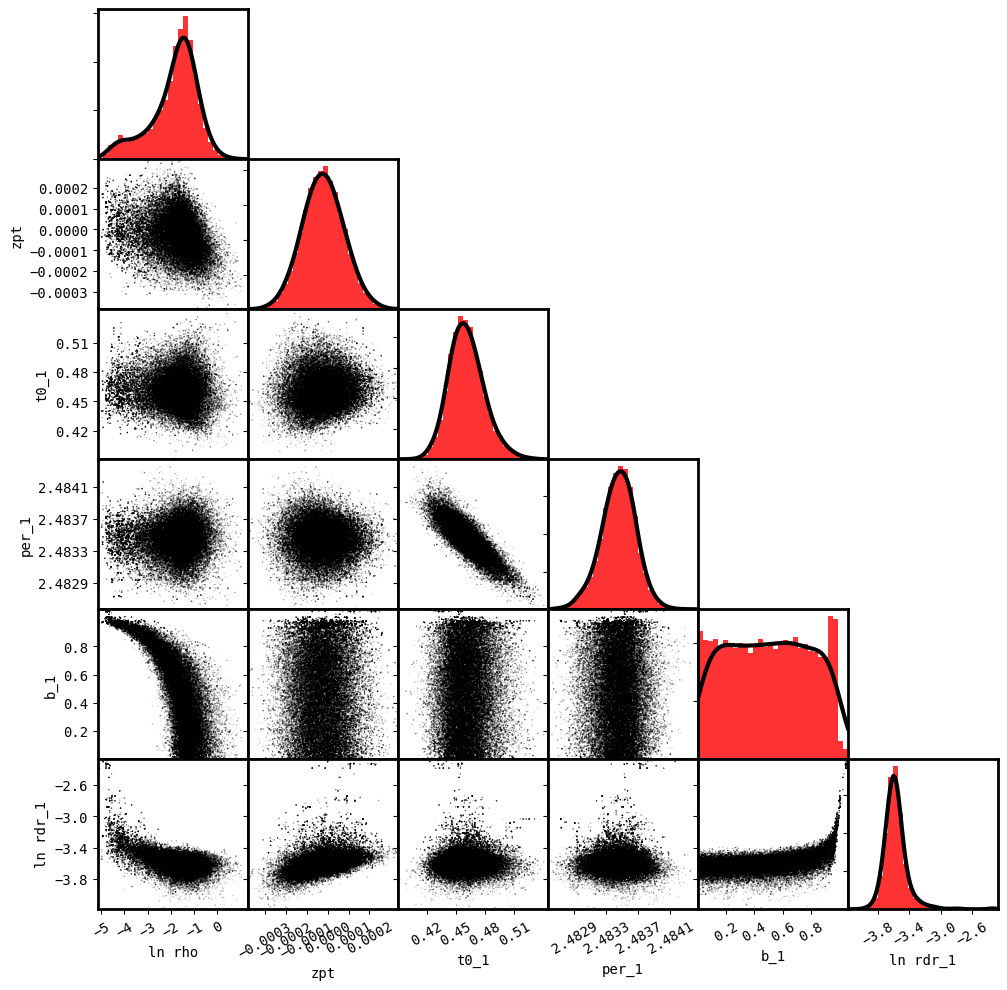

In [22]:
label = ["ln rho", "zpt", "t0_1", "per_1", "b_1", "ln rdr_1", "t0_2", "per_2", "b_2", "ln rdr_2", "t0_3", "per_3", "b_3", "ln rdr_3"]
color = ["red"]*14

plt.rcParams['font.size'] = 10
mcmc.triplot(chain, burnin, label, color, 30)

In [23]:
sol_mcmc = tmcmc.getParams(chain, burnin, sol, params_to_fit)
transitp.printParams(sol_mcmc)

ρ* (g/cm³):                     0.1926366 ± 0.1956462
c1:                                   0.0 ± 0.0
c2:                                   0.0 ± 0.0
q1:                             0.3545084 ± 0.0000000
q2:                             0.3205229 ± 0.0000000
Dilution:                             0.0 ± 0.0
Velocity Offset:                      0.0 ± 0.0
Photometric zero point:        -2.279e-05 ± 9.774e-05
t0 (days):                      0.4598728 ± 0.0178399
Period (days):                  2.4834578 ± 0.0002147
Impact parameter:               0.5015024 ± 0.2932160
Rp/R*:                          0.0275615 ± 0.0042605
sqrt(e)cos(w):                        0.0 ± 0.0
sqrt(e)sin(w):                        0.0 ± 0.0
RV Amplitude (m/s):                   0.0 ± 0.0
Thermal eclipse depth (ppm):          0.0 ± 0.0
Ellipsoidal variations (ppm):         0.0 ± 0.0
Albedo amplitude (ppm):               0.0 ± 0.0


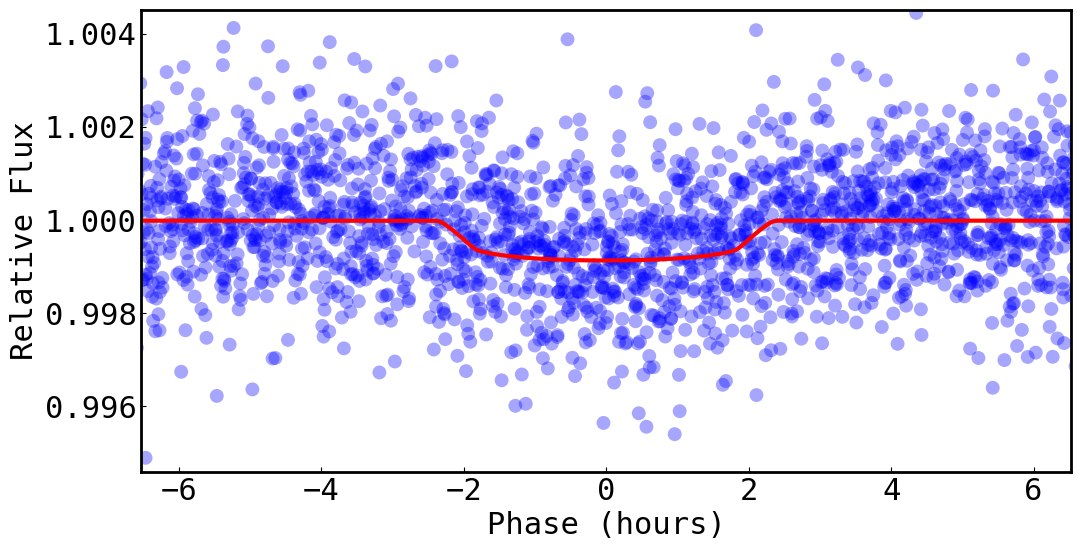

In [24]:
pl_plot = 1
transitp.plotTransit(phot, sol_mcmc, pl_to_plot=pl_plot, zerotime=gbls_inputs.zerotime)

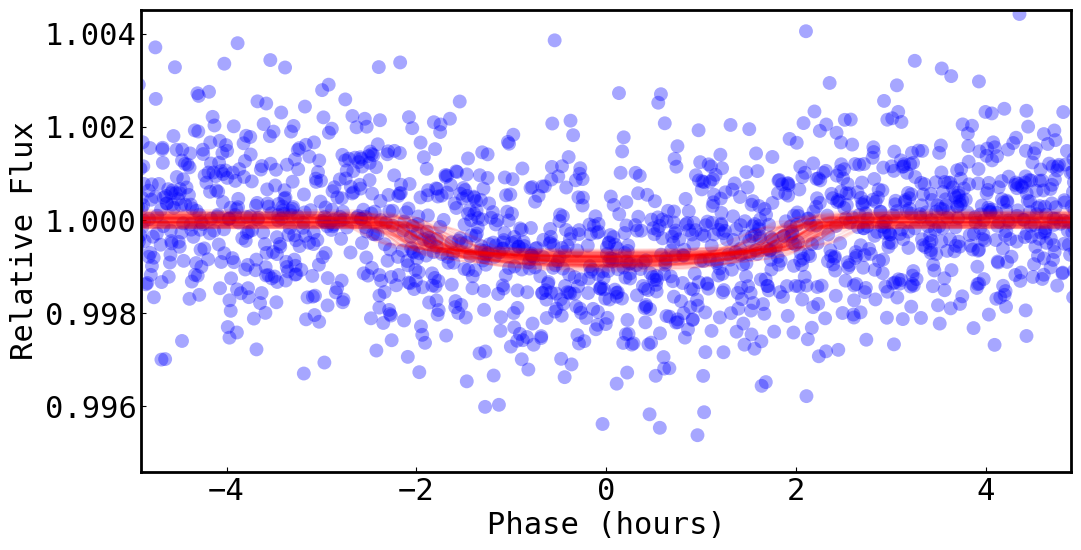

In [25]:
tmcmc.plotChainsTransit(phot, chain, burnin, sol, params_to_fit, zerotime=gbls_inputs.zerotime, nplot=100)